# DM-Baryon Scattering Constraints via Half-Mode Mass Limit

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from chainconsumer import ChainConsumer
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
from plot import plot_limit, plot_limit_fill, plot_limit_patch

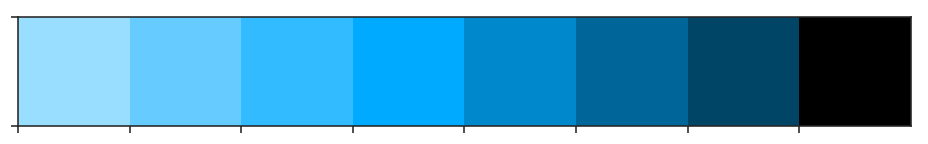

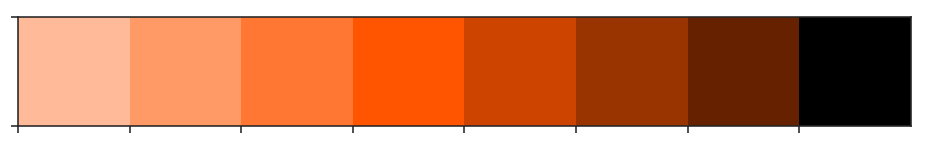

In [2]:
#Custom monochromatic palette (200 degree hue)
import seaborn as sns
sns.set_style("ticks")

green = sns.light_palette("green")[5]
cyan = sns.light_palette("turquoise")[5]
blue = sns.light_palette("blue")[5]
red = sns.light_palette("red")[5]
pink = sns.light_palette("magenta")[5]

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
sns.palplot(custom_blues)
sns.palplot(custom_blues_complement)

### Analytic relations between $k_{\rm{hm}}$, $M_{\rm{hm}}$, $m_{\rm{WDM}}$

In [3]:
h = 0.6727
omega_m = (0.1199)/(h**2)
rho_crit = 1.256*10**11*omega_m #Msun/Mpc^3

In [4]:
def khm(mwdm):
    lambda_fs = (0.049*(mwdm**(-1.11))*((omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    lambda_hm = 13.93*lambda_fs
    k_hm = 2*np.pi/lambda_hm
    return k_hm

In [5]:
def mwdm(Mhm):
    lambda_hm = 2.*(((3./4)*Mhm/(np.pi*rho_crit))**(1./3))
    lambda_fs = lambda_hm/13.93
    mwdm = (h*lambda_fs/(0.049*((omega_m/0.25)**(0.11))*((h/0.7)**1.22)))**(1./-1.11)
    return mwdm

In [6]:
def khm2(Mhm):
    return khm(mwdm(Mhm))

In [7]:
#sanity check
print(mwdm(3.1*10**8))
print(khm(mwdm(3.1*10**8)))
print(khm2(3.1*10**8))

3.270976419
35.7788248842
35.7788248842


In [8]:
#Constraints derived from MW satellites
Mmin_constraint = 5.4*10**8 #Msun
kcrit_constraint = khm2(Mmin_constraint) #h/Mpc

Mhm_constraint = 3.1*10**8 #Msun
khm_constraint = khm2(Mhm_constraint) #h/Mpc
mwdm_constraint = mwdm(Mhm_constraint) #keV

### Analytic calculation of $k_{\rm{crit}}(\sigma_0,m_\chi)$

In [9]:
npows = [0]
masses_test = [1e-5,1e-4,1e-3,1e-2,1e-1,1.,10.,100.]
sigmas_test = np.logspace(-26,-30,20)

In [10]:
def hubble_rate_RD(H0=67.27,Mpc2cm=3.086e24,omega_rad=9.23640e-5,z=1e4):
    """
    hubble rate in radiation domination, in km/sec/Mpc.
    """
    return H0*np.sqrt(omega_rad)*z**2

In [11]:
def z_decoupling_simple(mchi,sigma0,omega_b=0.05,omega_rad=9.23640e-5,
                 H0=67.27,kT0=2.353e-13,rho_crit=4.755e-6,
                 cc=3e5,Mpc2cm=3.086e24,mp=1.,Yhe=0.25,n=0.):
    
    N0 = pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))
    prefac = H0*np.sqrt(omega_rad)/(N0*(1.-Yhe)*omega_b*rho_crit*np.sqrt(kT0)*cc*Mpc2cm)
    sol = prefac*np.sqrt(mchi+mp)*np.sqrt(mchi*mp)/sigma0
    solprime = prefac*((mchi+mp)/mchi)*np.sqrt(mchi+mp)*np.sqrt(mchi*mp)/sigma0
    zdec = np.power(sol,2./3.)
    zdecprime = np.power(solprime,2./3.)
    
    return zdec, zdecprime

In [12]:
def z_decoupling_temp(mchi,sigma0,omega_b=0.05,omega_rad=9.23640e-5,
                      H0=67.27,kT0=2.353e-13,rho_crit=4.755e-6,
                      cc=3e5,Mpc2cm=3.086e24,mp=1.,Yhe=0.25,n=0):
    
    N0 = pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))
    mu = mchi*mp/(mchi+mp)
    RHS = H0*np.sqrt(omega_rad)/(N0*(1.-Yhe)*omega_b*rho_crit*cc*Mpc2cm)
    RHS *= (mchi+mp)**2 / (sigma0 * mchi) * pow(mu/kT0,(n+1.)/2.)
    zdec = np.power(RHS,2./(n+3.))
    
    return zdec

In [13]:
def z_decoupling(mchi,sigma0,omega_b=0.05,omega_rad=9.23640e-5,
                 H0=67.27,kT0=2.353e-13,rho_crit=4.755e-6,
                 cc=3e5,Mpc2cm=3.086e24,mp=1.,Yhe=0.25,n=0):
    
    N0 = pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))
    mu = mchi*mp/(mchi+mp)
    RHS = H0*np.sqrt(omega_rad)/(N0*(1.-Yhe)*omega_b*rho_crit*cc*Mpc2cm)
    RHS *= (mchi+mp)/sigma0
    RHS = (mchi+mp)*mu/kT0 * pow(RHS,2./(n+1.))
    
    zdec_temp = z_decoupling_temp(mchi,sigma0,omega_b=omega_b,omega_rad=omega_rad,H0=H0,kT0=kT0,
                                  rho_crit=rho_crit,cc=cc,Mpc2cm=Mpc2cm,mp=mp,Yhe=Yhe,n=n)
    
    func = lambda z: pow(z,(n+3.)/(n+1.)) * (z*mp/(1.+zdec_temp) + mchi) - RHS
    sol = fsolve(func,zdec_temp/2.)
    
    return sol

In [14]:
def k_crit(mchi,sigma0,omega_b=0.05,omega_rad=9.23640e-5,
                 H0=67.27,kT0=2.353e-13,rho_crit=4.755e-6,
                 cc=3e5,Mpc2cm=3.086e24,reduction_factor=1.,mp=1.,Yhe=0.25,n=0.):
    """
    reduction_factor increases k_decoupling to smaller scales, 
    to account for the fact that decoupling becomes important
    when the interaction rate per DM particle is >> H.
    """
    
    zdec = z_decoupling(mchi,sigma0,omega_b=omega_b,omega_rad=omega_rad,H0=H0,
                        kT0=kT0,rho_crit=rho_crit,cc=cc,Mpc2cm=Mpc2cm,mp=mp,Yhe=Yhe,n=n)
    
    zdec_rchi,zdec_rchiprime = z_decoupling_simple(mchi,sigma0,omega_b=omega_b,omega_rad=omega_rad,
                       H0=H0,kT0=kT0,rho_crit=rho_crit,cc=cc,Mpc2cm=Mpc2cm,mp=mp,Yhe=Yhe,n=n)
    
    H = hubble_rate_RD(H0=H0,Mpc2cm=Mpc2cm,omega_rad=omega_rad,z=zdec)
    H_rchi = hubble_rate_RD(H0=H0,Mpc2cm=Mpc2cm,omega_rad=omega_rad,z=zdec_rchi)
    H_rchiprime = hubble_rate_RD(H0=H0,Mpc2cm=Mpc2cm,omega_rad=omega_rad,z=zdec_rchiprime)
    
    lambda_dec = zdec * cc / H #in Mpc comoving.
    lambda_dec_rchi = zdec_rchi * cc / H_rchi
    lambda_dec_rchiprime = zdec_rchiprime * cc / H_rchiprime
    
    kdec = 2./ lambda_dec
    kdec_rchi = 2./ lambda_dec_rchi
    kdec_rchiprime = 2./ lambda_dec_rchiprime
    
    return kdec * reduction_factor, kdec_rchi * reduction_factor, kdec_rchiprime * reduction_factor

In [15]:
sigma_fs = np.zeros(len(masses_test))
sigma_fs_rchi = np.zeros(len(masses_test))
sigma_fs_rchiprime = np.zeros(len(masses_test))

sigma_array = np.logspace(-23,-32,1000)
for i in range(len(masses_test)):
    mchi=masses_test[i]
    kdec, kdec_rchi, kdec_rchiprime = k_crit(mchi, sigma0=sigma_array,reduction_factor=1.0)
    sigma_fs[i] = sigma_array[np.argmin(np.abs(kdec-h*kcrit_constraint))]
    sigma_fs_rchi[i] = sigma_array[np.argmin(np.abs(kdec_rchi-h*kcrit_constraint))]
    sigma_fs_rchiprime[i] = sigma_array[np.argmin(np.abs(kdec_rchiprime-h*kcrit_constraint))]

### Numerical Calculation of $k_{\rm{hm}}(\sigma_0,m_\chi)$

In [16]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=sigmas_test,
           pk_root='../data/pk_output/', trust_cut=66,reduction_factor=0.75):
    
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    khms = []
    ss = []
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
        #print filename
        data = np.loadtxt(filename)
        pk = data[:,1]
   
        ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
        if ks[ind]<=trust_cut:
            khms.append(ks[ind])
            ss.append(sigmas[i])
    p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    return np.array(ss),np.array(khms),p

def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

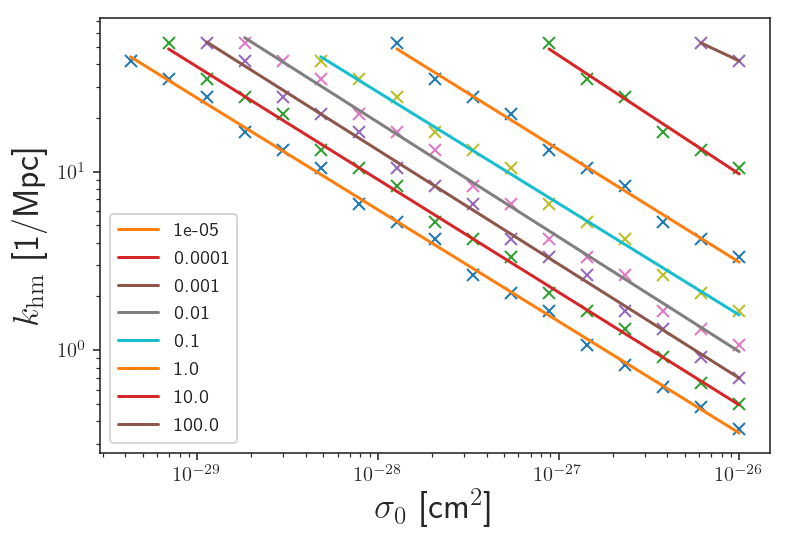

In [17]:
f,ax = plt.subplots()

for m in masses_test:
    sigmas, kcuts, p = calculate_kcuts(npow=0, m=m, z='z1')
    ax.loglog(sigmas,kcuts,'x')
    ax.loglog(sigmas,fit_fun(sigmas,p),label='{}'.format(m))

ax.legend()
ax.set_xlabel(r'$\sigma_0$ [cm$^2$]',fontsize=18)
ax.set_ylabel(r'$k_{\rm{hm}}$ [1/Mpc]',fontsize=18)
plt.show()

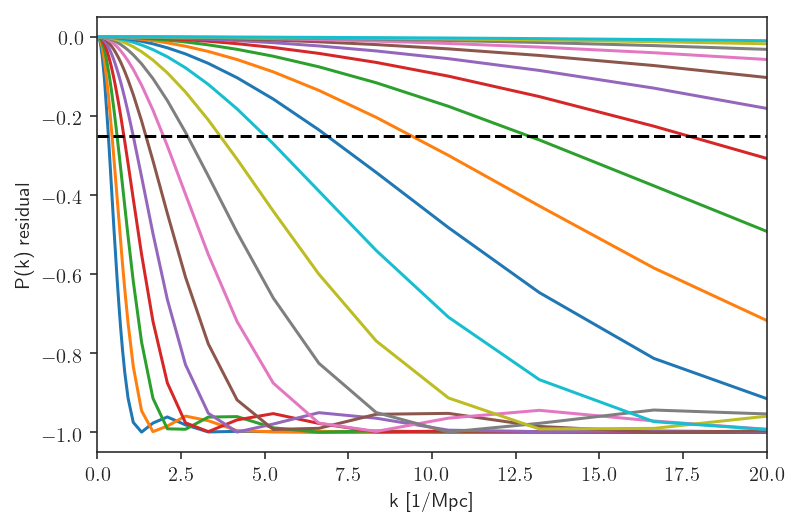

In [18]:
def show_pk(npow=0,m=1e-3,sigmas=sigmas_test,z='z1',
           pk_root='../data/pk_output/',
           f=None,ax=None,xmin=0,xmax=20,
           show_kcut=True,pfit=p):
    if (ax is None) or (f is None):
        f,ax = plt.subplots()
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    #ax.plot(ks,pk0/pk0)
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
        #print filename
        data = np.loadtxt(filename)
        pk = data[:,1]
        ax.plot(ks,(pk-pk0)/pk0,label=r'{}cm$^2$'.format(sigma))
        if show_kcut:
            kcut = fit_fun(sigmas[i],p)
            plt.axvline(x=kcut,color='k')
    #plt.legend()
    ax.plot(ks,-ks/ks*0.25,'--',color='k')
    ax.set_xlim(xmax=xmax,xmin=xmin)
    ax.set_xlabel('k [1/Mpc]')
    ax.set_ylabel('P(k) residual')
    
show_pk()    

Finally, save a large array of sigma vs khms:

In [19]:
sigmas_ref = np.logspace(-23,-33,1000)
for m in masses_test:
    ks_filename = '../data/khm/ks_0.25_z0_n0_m{}.txt'.format(m)
    sigmas, kcuts, p = calculate_kcuts(npow=0, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

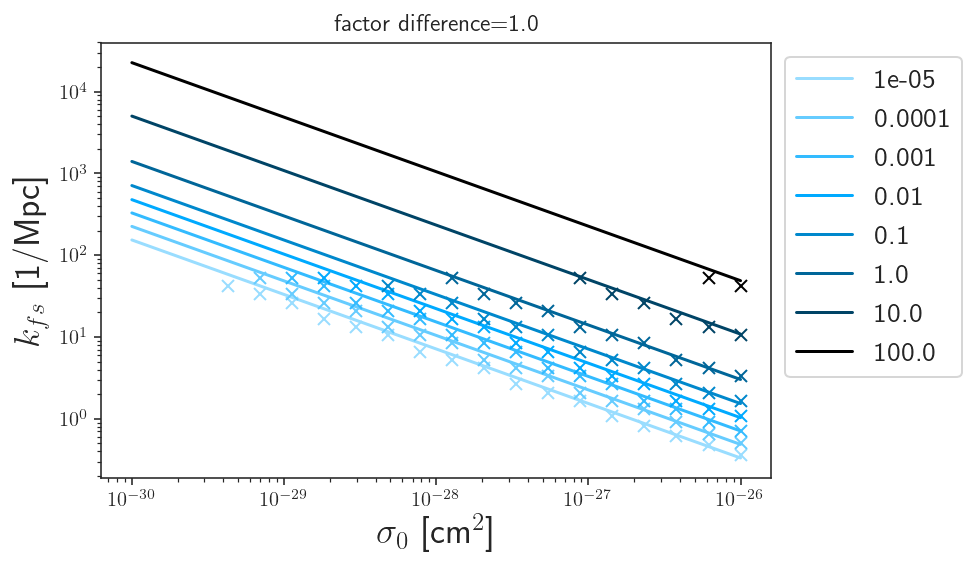

In [20]:
reduction_factor = 1.
sigma0s = np.logspace(-26,-30,100)

f,ax = plt.subplots()

for i in range(len(masses_test)):
    mchi=masses_test[i]
    kdecs, kdecs_rchi, kdecs_rchiprime = k_crit(mchi, sigma0=sigma0s,reduction_factor=reduction_factor)
    sigmas, kcuts, p = calculate_kcuts(npow=0, m=mchi, z='z1')
    ax.loglog(sigma0s,kdecs,label='{}'.format(mchi),c=custom_blues[i])
    ax.loglog(sigmas,kcuts,'x',c=custom_blues[i])
ax.legend(fontsize=14, bbox_to_anchor=(1.0,1.0))
ax.set_xlabel(r'$\sigma_0$ [cm$^2$]',fontsize=18)
ax.set_ylabel(r'$k_{fs}$ [1/Mpc]',fontsize=18)
ax.set_title('factor difference={}'.format(reduction_factor))

plt.show()

In [21]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    f,ax = plt.subplots()
    f2,ax2 = plt.subplots()
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))
    xmin = masses.min()
    xmax = masses.max()
    for i,m in enumerate(masses):
        ks_filename = '../data/khm/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
        
        if plot_ks:
            ax2.loglog(ss,ks)
    if plot_ks:
        ax2.loglog(np.array([ss.min(),ss.max()]),np.array([kcut,kcut]),color='k')
        ax2.set_xlabel(r'$\sigma_0$ [cm$^2$]',fontsize=18)
        ax2.set_ylabel(r'$k$ [1/Mpc]',fontsize=18)
        ax2.annotate(r'$k_{cutoff}$',(1e-26,100),fontsize=19)
        
    ax.loglog(masses,sigmas,lw=3)
    ax.fill_between(masses,sigmas,ymax,alpha=0.5)
    ax.set_xlabel('DM mass [GeV]')
    ax.set_ylabel(r'cross section [cm$^2$]')
    ax.set_xlim(xmin=xmin,xmax=xmax)
    #ax.set_ylim(ymax=ymax,ymin=ymin)
    ax.annotate('Excluded by MW satellites',(1.5e-5,1e-28),fontsize=19)
    f.savefig('limit.png',bbox_inches = "tight")
          
    return masses,sigmas

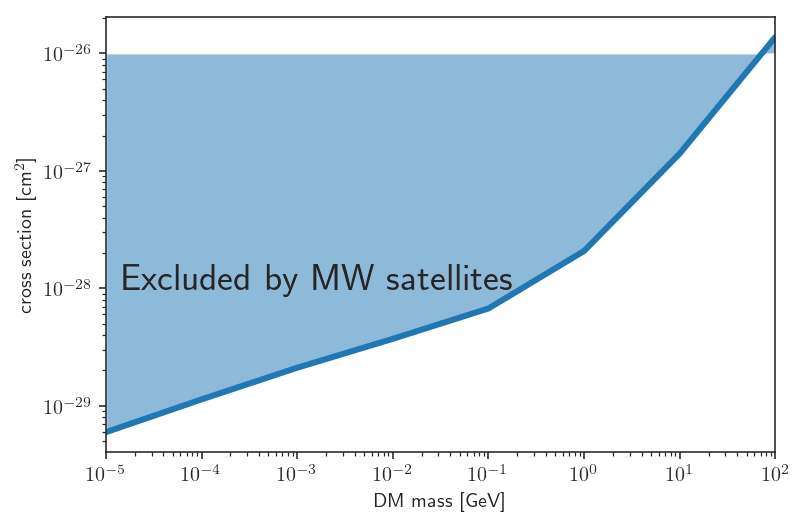

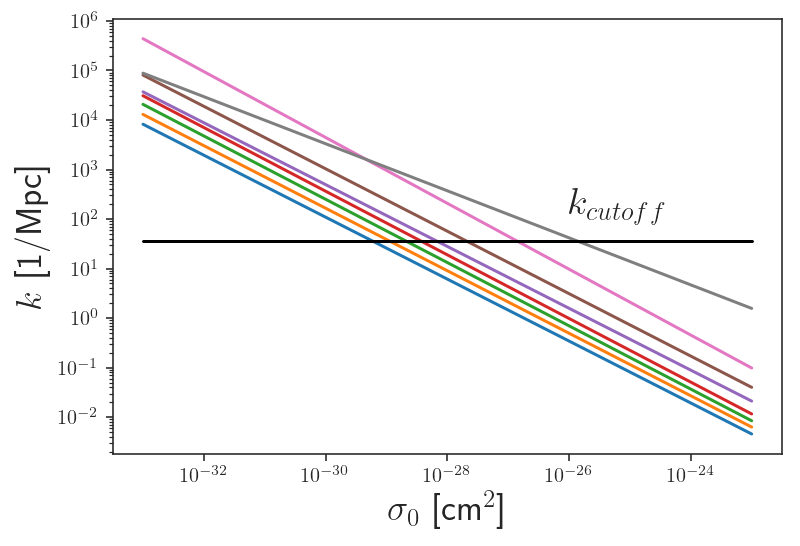

In [22]:
masses,sigmas=sigma0_limit(kcut=khm_constraint)

Verify $k_{\rm{hm}}$ calculation

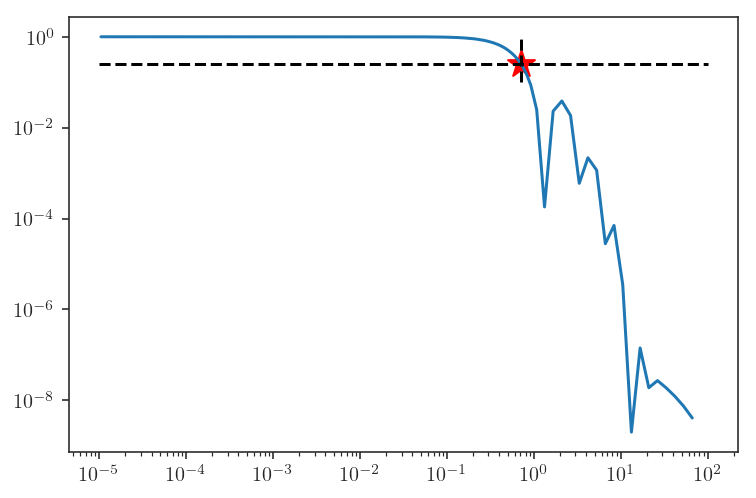

In [23]:
pk_root='../data/pk_output/'
data0 = np.loadtxt(pk_root + 'lcdm_z1_pk.dat')
ks = data0[:,0]
pk0 = data0[:,1]

data = np.loadtxt('../data/pk_output/n0_m0.001_s1e-26_z1_pk.dat')
pk = data[:,1]
arg = np.argmin(np.abs(pk/pk0 - 0.25))

ks_test = np.loadtxt('../data/khm/ks_0.25_z0_n0_m0.001.txt')

plt.loglog(ks,pk/pk0)#,label=r'{}cm$^2$'.format(sigma))
plt.plot(np.ones(10)*ks[arg],np.linspace(0.1,1.,10),'k--')
plt.plot(np.linspace(1e-5,1e2,10),0.25*np.ones(10),'k--')
plt.scatter(ks_test[np.argmin(np.abs(sigmas_ref-10**-26))][1],0.25,marker='*',s=200,c='r')

plt.show()

### Relate DM-Baryon scattering and WDM parameters

In [24]:
ks_all = []
mwdm_match_all = []
mwdm_array = np.logspace(-3,3,1e4)

for i,m in enumerate(masses):
    ks_test = np.loadtxt('../data/khm/ks_0.25_z0_n0_m{}.txt'.format(m))
    ks_all.append(ks_test)
    mwdm_match = np.zeros(len(ks_test[:,1]))
    for i in range(len(ks_test[:,1])):
        mwdm_match[i] = mwdm_array[np.argmin(np.abs(ks_test[:,1][i]-khm(mwdm_array)))]
    mwdm_match_all.append(mwdm_match)

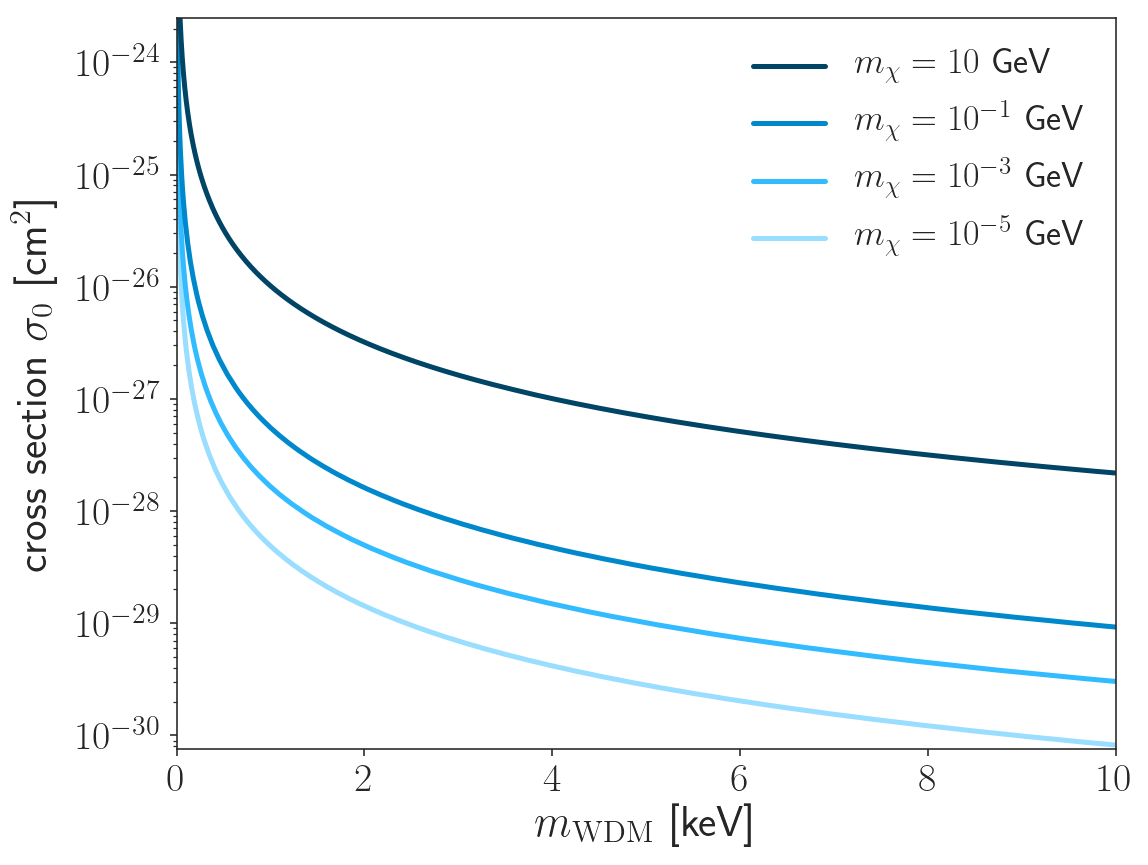

In [25]:
handles = []

plt.figure(figsize=(8,6))

hs = plt.semilogy(mwdm_match_all[0],ks_all[0][:,0],label=r'$m_\chi = 10^{-5}$ GeV',lw=2.5,c=custom_blues[0])#.format(np.abs(i-5)),c=custom_blues[i],lw=2.5)
handles.append(hs[0])

hs = plt.semilogy(mwdm_match_all[2],ks_all[2][:,0],label=r'$m_\chi = 10^{-3}$ GeV',lw=2.5,c=custom_blues[2])
handles.append(hs[0])

hs = plt.semilogy(mwdm_match_all[4],ks_all[4][:,0],label=r'$m_\chi = 10^{-1}$ GeV',lw=2.5,c=custom_blues[4])
handles.append(hs[0])

hs = plt.semilogy(mwdm_match_all[6],ks_all[6][:,0],label=r'$m_\chi = 10$ GeV',lw=2.5,c=custom_blues[6])
handles.append(hs[0])

plt.legend(loc=1,prop={'size':18},frameon=False,handles=handles[::-1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,10)
plt.ylim(0.75*10**-30,2.5*10**-24)
plt.xlabel(r'$m_{\rm{WDM}}$ [keV]',fontsize=22)
plt.ylabel('cross section $\sigma_0$ [cm$^2$]',fontsize=22,labelpad=8)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0.15,bottom=0.12)
plt.savefig('sigma_mwdm.pdf')
plt.show()

Create interpolating function, and check that it works

In [26]:
sigma_mwdm_fit = []
for i in range(len(masses)):
    sigma_mwdm = interp1d(mwdm_match_all[i], ks_all[i][:,0], kind='linear')
    sigma_mwdm_fit.append(sigma_mwdm)

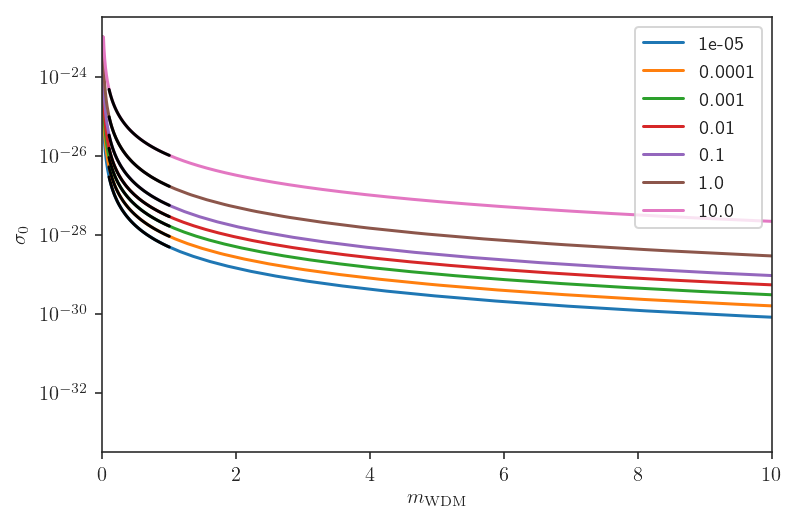

In [27]:
for i in range(len(masses)-1):
    plt.semilogy(mwdm_match_all[i],ks_all[i][:,0],label=masses[i])
    plt.plot(np.linspace(0.1,1.,100),sigma_mwdm_fit[i](np.linspace(0.1,1.,100)),'k')

    plt.legend(loc=1)
plt.xlim(0,10)
plt.xlabel(r'$m_{\rm{WDM}}$')
plt.ylabel(r'$\sigma_0$')

plt.show()    

Check that $\sigma_0(m_{\rm{WDM}})$ is consistent with the WDM transfer function

In [28]:
def transfer(k,mwdm):
    nu = 1.12
    lambda_fs = (0.049*(mwdm**(-1.11))*((omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    alpha = lambda_fs
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

In [29]:
sigma_example = 1.12883789168*10**-29
mwdm_match_example = mwdm_match_all[2][np.argmin(np.abs(sigma_mwdm_fit[2](mwdm_match_all[2])-sigma_example))]
print((sigma_mwdm_fit[2](mwdm_match_example)-sigma_example)/sigma_example)

sigma_example2 = 2.97635144163*10**-29
mwdm_match_example2 = mwdm_match_all[2][np.argmin(np.abs(sigma_mwdm_fit[2](mwdm_match_all[2])-sigma_example2))]
print((sigma_mwdm_fit[2](mwdm_match_example2)-sigma_example2)/sigma_example2)

0.0032807398654077853
0.0018213065546846706


In [30]:
data = np.loadtxt('../data/pk_output/n0_m0.001_s1.12883789168e-29_z1_pk.dat')
pk = data[:,1]

data2 = np.loadtxt('../data/pk_output/n0_m0.001_s2.97635144163e-29_z1_pk.dat')
pk2 = data2[:,1]

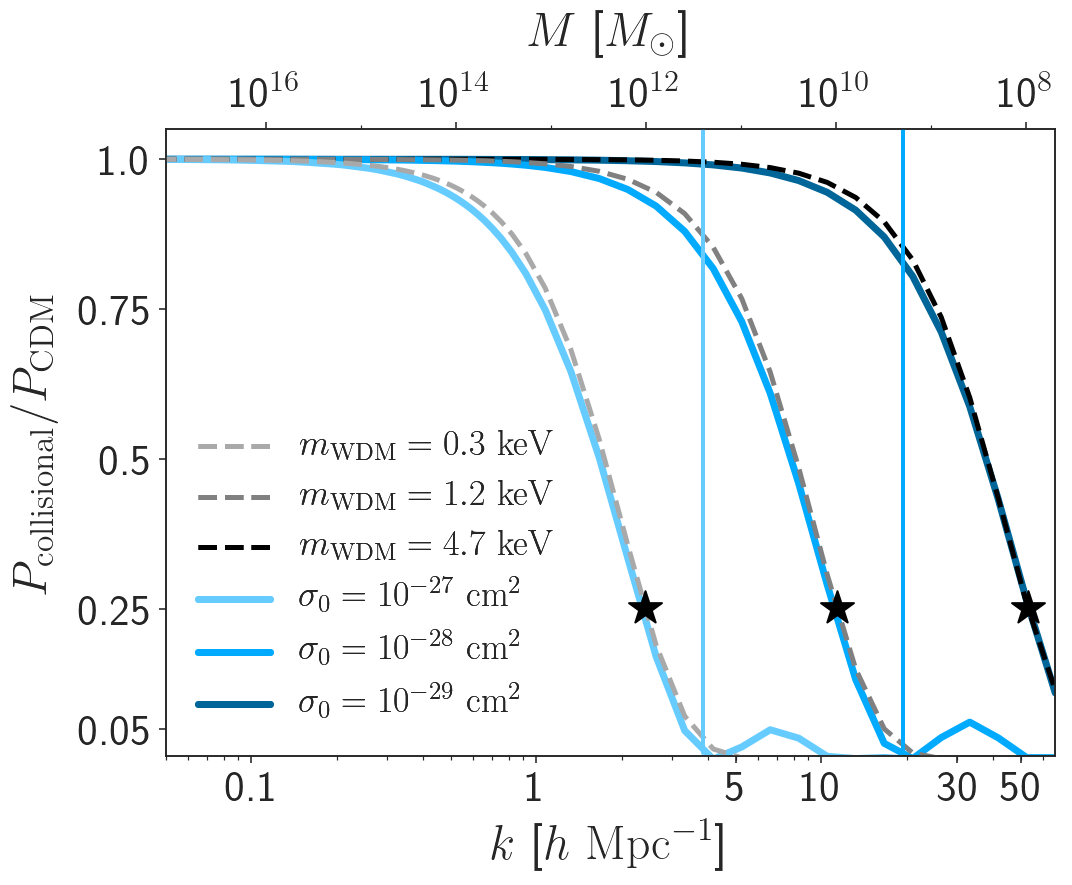

In [31]:
fig = plt.figure(figsize=(7.5,6.25))
ax = fig.add_subplot(111)
ax2 = ax.twiny()
ax.set_xscale('log')

pk_root='../data/pk_output/'
data0 = np.loadtxt(pk_root + 'lcdm_z1_pk.dat')
ks = data0[:,0]
pk0 = data0[:,1]

data = np.loadtxt('../data/pk_output/n0_m0.001_s1.2742749857e-28_z1_pk.dat')
pk = data[:,1]
mwdm_match_example = mwdm_match_all[2][np.argmin(np.abs(sigma_mwdm_fit[2](mwdm_match_all[2])-1.2742749857*10**-28))]

data2 = np.loadtxt('../data/pk_output/n0_m0.001_s1.43844988829e-27_z1_pk.dat')
pk2 = data2[:,1]
mwdm_match_example2 = mwdm_match_all[2][np.argmin(np.abs(sigma_mwdm_fit[2](mwdm_match_all[2])-1.43844988829*10**-27))]

data3 = np.loadtxt('../data/pk_output/n0_m0.001_s1.12883789168e-29_z1_pk.dat')
pk3 = data3[:,1]
mwdm_match_example3 = mwdm_match_all[2][np.argmin(np.abs(sigma_mwdm_fit[2](mwdm_match_all[2])-1.12883789168e-29))]

sigma3= ax.semilogx(ks,pk3/pk0,label=r'$\sigma_0 = 10^{-29}\ \rm{cm}^2$',c=custom_blues[5],lw=3.5)
sigma1= ax.semilogx(ks,pk/pk0,label=r'$\sigma_0 = 10^{-28}\ \rm{cm}^2$',c=custom_blues[3],lw=3.5)
sigma2= ax.semilogx(ks,pk2/pk0,label=r'$\sigma_0 = 10^{-27}\ \rm{cm}^2$',c=custom_blues[1],lw=3.5)

wdm3= ax.semilogx(ks,transfer(ks,mwdm_match_example3)**2,linestyle='--',label=r'$m_{\rm{WDM}} = 4.7\ \rm{keV}$',c='k',lw=2.5,zorder=998)
wdm1= ax.semilogx(ks,transfer(ks,mwdm_match_example)**2,linestyle='--',label=r'$m_{\rm{WDM}} = 1.2\ \rm{keV}$',c='gray',alpha=1.0,lw=2.5,zorder=998)
wdm2= ax.semilogx(ks,transfer(ks,mwdm_match_example2)**2,linestyle='--',label=r'$m_{\rm{WDM}} = 0.3\ \rm{keV}$',c='darkgray',alpha=1.0,lw=2.5,zorder=998)

arg = np.argmin(np.abs(pk/pk0 - 0.25))
ks_test = np.loadtxt('../data/khm/ks_0.25_z0_n0_m0.001.txt')
ax.plot(np.ones(10)*k_crit(10**-3, sigma0=1.2742749857*10**-28,reduction_factor=1.0)[0]/h,np.linspace(0.01,1.05,10),linewidth=2,c=custom_blues[3],alpha=1.0,zorder=999)
ax.plot(np.ones(10)*k_crit(10**-3, sigma0=1.43844988829e-27,reduction_factor=1.0)[0]/h,np.linspace(0.01,1.05,10),linewidth=2,c=custom_blues[1],alpha=1.0,zorder=999)

ax.scatter(ks_test[np.argmin(np.abs(sigmas_ref-1.2742749857*10**-28))][1],0.253,marker='*',s=300,edgecolor='k',facecolor='k',alpha=1.0,zorder=999)
ax.scatter(ks_test[np.argmin(np.abs(sigmas_ref-1.43844988829e-27))][1],0.253,marker='*',s=300,edgecolor='k',facecolor='k',alpha=1.0,zorder=999)
ax.scatter(ks_test[np.argmin(np.abs(sigmas_ref-1.12883789168e-29))][1],0.253,marker='*',s=300,edgecolor='k',facecolor='k',alpha=1.0,zorder=999)

ax.set_xlim(0.05,66)
ax.set_ylim(0.005,1.05)
ax.set_ylabel(r'$P_{\rm{collisional}}/P_{\rm{CDM}}$',fontsize=24,labelpad=8)
first_legend = ax.legend(handles=[wdm2[0],wdm1[0],wdm3[0],sigma2[0],sigma1[0],sigma3[0]], frameon=False, loc=3, prop={'size':18})
ax.add_artist(first_legend)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=24)
ax.set_xticks([0.1,1,5,10,30,50])
ax.set_xticklabels([0.1,1,5,10,30,50],fontsize=22)
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=22)

ax2.set_xscale('log')
ax2.set_xlim(0.05,66)
ax2.set_xticks([khm2(10**16),khm2(10**14),khm2(10**12),khm2(10**10),khm2(10**8)])
ax2.set_xticks([khm2(10**15),khm2(10**13),khm2(10**11),khm2(10**9)],minor=True)
ax2.set_xticklabels([r'10$^{16}$',r'10$^{14}$',r'10$^{12}$',r'10$^{10}$',r'10$^{8}$'],fontsize=22)
ax2.set_xticklabels([r'',r'',r'',r''],minor=True)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=24,labelpad=12)

plt.tight_layout()
plt.gcf().subplots_adjust(left=0.15)
plt.savefig('pspec.pdf')
plt.show()

### Plot limits

In [32]:
sigma_mass_lims = np.zeros(len(masses))
for i in range(len(masses)):
    sigma_mass_lims[i] = sigma_mwdm_fit[i](mwdm_constraint)

In [33]:
def sigma0_limit(masses=masses_test, npow=0,z=0,ymax=2e-24,ymin=1e-34,
                 plot_ks=False,plot_fs=True, plot_rchi=False, plot_rchiprime=False):
    
    f,ax = plt.subplots(figsize=(8,6))    
    masses = np.array(masses)
    xmin = masses.min()
    xmax = masses.max()
        
    if plot_fs:
        ax.loglog(masses_test,sigma_fs,c=custom_blues[4],ls='--',lw=1.55,label=r'Analytic Estimate')
        
    if plot_rchi:
        ax.loglog(masses_test,sigma_fs_rchi,c=custom_blues[4],ls='--',lw=1.5)
        
    if plot_rchiprime:
        ax.loglog(masses_test,sigma_fs_rchiprime,c=custom_blues[4],ls='--',lw=1.5)
        
    ax.loglog(masses,sigma_mass_lims,c=custom_blues[4],lw=3,label=r'Population Analysis')
        
    ax.fill_between(masses,sigma_mass_lims,ymax,edgecolor='r',
                     facecolor=custom_blues[4],alpha=0.3)
    
    limits = yaml.load(open('bsdm_limits.yaml'))
    
    plot_limit_patch(limits['emken2018_updated'],zorder=999)
    plot_limit_patch(limits['bringmann2018_v3_xenon1t'],zorder=1)
    plot_limit_patch(limits['bringmann2018_v3_miniboone'],zorder=1)
    plot_limit_fill(limits['gluscevic2018_planck'])
    plot_limit_patch(limits['erickcek2007_xqc'],zorder=1)
    plot_limit_fill(limits['xu2018_lya'])
    plt.plot(np.linspace(0.139,0.1402,10),np.linspace(9.625e-28,7.5825e-31,10),'k',alpha=0.15,zorder=1,linewidth=0.95)
            
    ax.set_xlabel('dark matter mass $m_\chi$ [GeV]',fontsize=24,labelpad=8)
    ax.set_ylabel('cross section $\sigma_0$ [cm$^2$]',fontsize=24,labelpad=8)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    ax.set_xlim(xmin=xmin,xmax=xmax)
    ax.set_ylim(ymax=ymax,ymin=ymin)
    ax.legend(loc=3,prop={'size':16},frameon=False)
    ax.annotate('Milky Way Satellites',(0.65e-3,3.05e-28),color=custom_blues[6],fontweight='bold',fontsize=18.5,rotation=6.3,zorder=999)
    ax.annotate('CMB',(1e-3,1e-25),color='k',fontsize=15,alpha=0.7)
    ax.annotate(r'Lyman-$\alpha$',(0.021,1.6e-26),color='k',fontsize=15,alpha=0.7)
    ax.annotate('Direct Detection',(0.85,8.5e-32),color='k',fontsize=15,alpha=0.7)
    ax.annotate('XQC',(6.5,1.5e-26),color='k',fontsize=15,alpha=0.7)
    ax.annotate('MiniBoone CR',(2.25e-5,1.1e-27),color='k',fontsize=15,alpha=0.7)
    ax.annotate('XENON1T CR',(7e-5,2.05e-30),color='k',fontsize=15,alpha=0.7)

    plt.tight_layout()
    f.savefig('limit3.pdf',bbox_inches = "tight")    
        
    return masses,sigmas

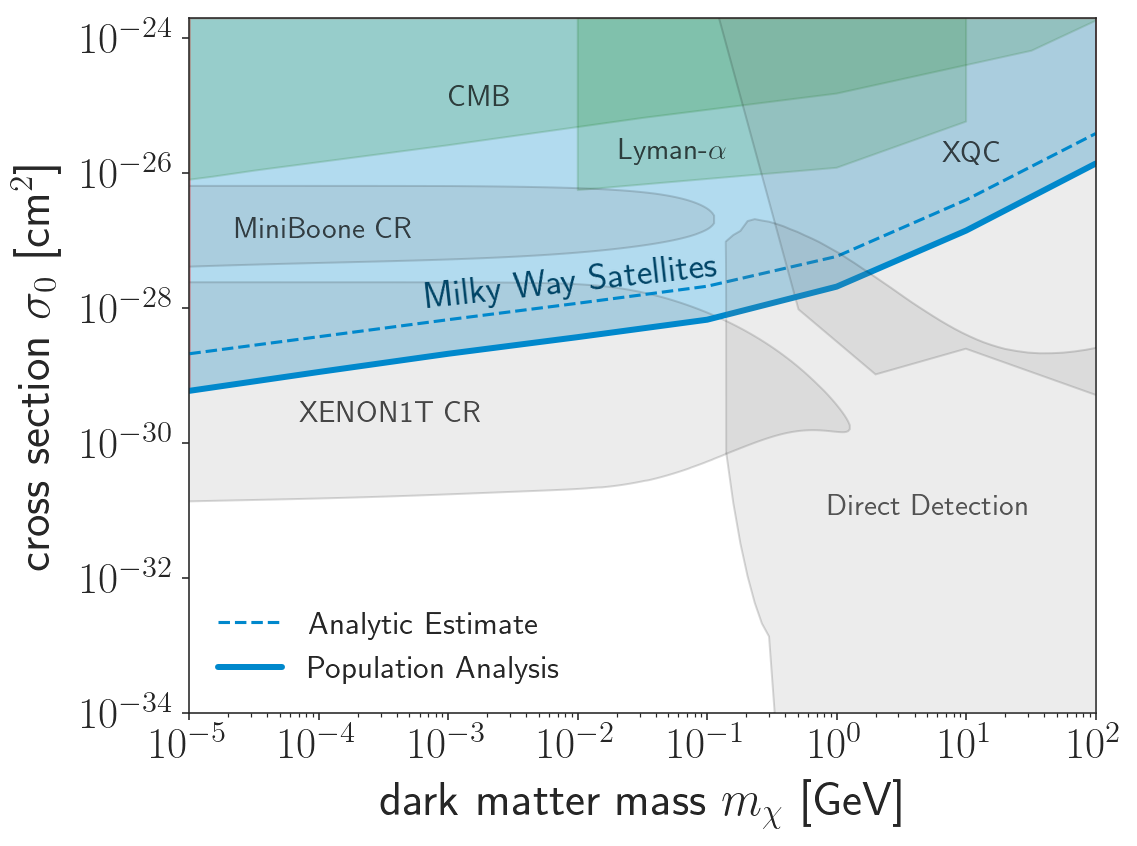

In [34]:
masses,sigmas=sigma0_limit(plot_fs=True,plot_rchi=False,plot_rchiprime=False)

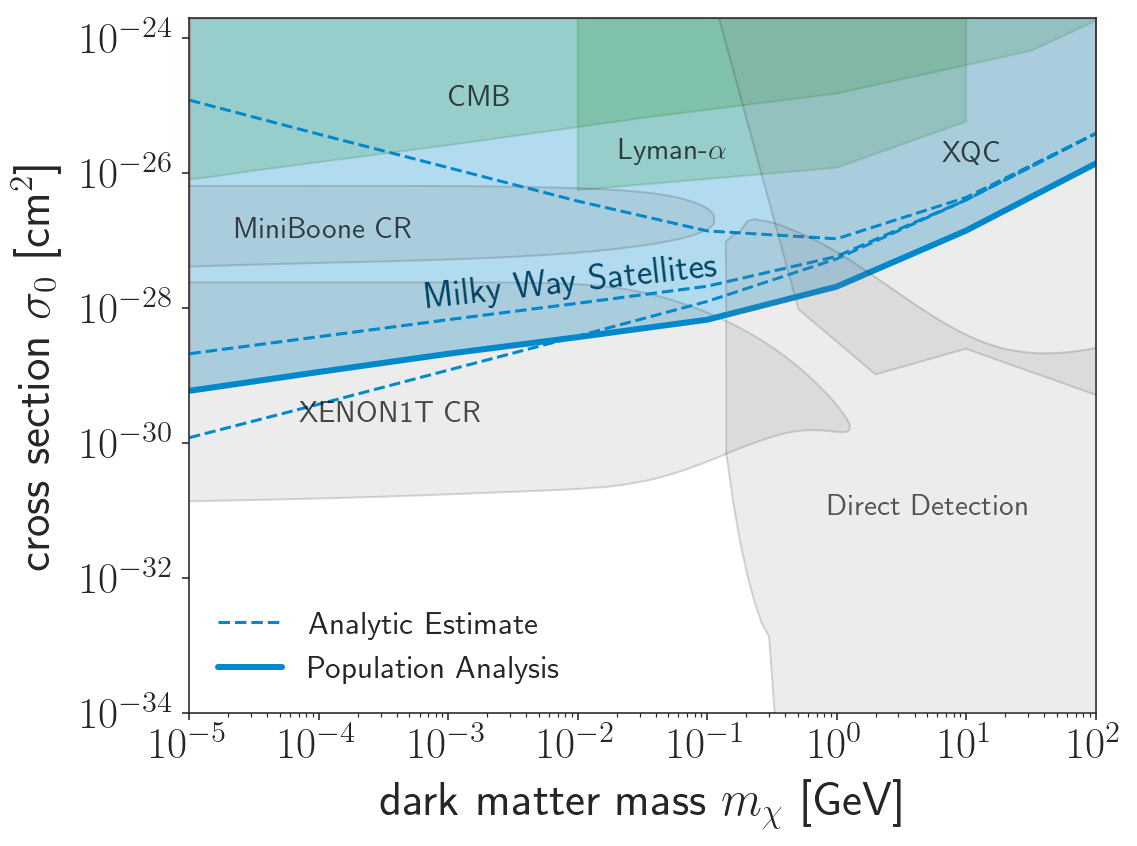

In [35]:
masses,sigmas=sigma0_limit(plot_fs=True,plot_rchi=True,plot_rchiprime=True)